Scan the entire market for setups

Start with the crypto market, scan for prices that are close to/around previous price rejection points zones.

Estimate the strength of these zones and determine if a breakout would suffice.

If a zone is probablistically weak, and it is a support than the price might break that zone.

# Install Libraries

In [ ]:
!pip install ccxt -qqq
!pip install yfinance -qqq
!pip install mplfinance -qqq

# Import Libraries

In [ ]:
import sys
import os
import time
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
from numpy.linalg import norm
from scipy.stats import entropy
from scipy.stats import entropy
from sklearn.cluster import Birch
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import ccxt
import logging
from pathlib import Path
from typing import List, Optional, Union

np.random.seed(0)

# Load Data


From any ccxt supported exchange.

coinbase, gemini, kraken, binanceus, etc

Recommended => Coinbase.



## CCXT

In [ ]:
INSTRUMENT = "SOL/USDT"
TIMEFRAME = "4h"
EXCHANGE_ID = "binanceus"

In [ ]:
# Instantiate the Coinbase exchange
exchange: ccxt.Exchange = getattr(ccxt, EXCHANGE_ID)()

# Load the markets to get exchange information, including timeframes
exchange.load_markets()

# Get and print the supported timeframes
exchange_timeframes = exchange.timeframes

if exchange_timeframes:
    print(f"Supported timeframes for {EXCHANGE_ID.capitalize()}:")
    for timeframe in exchange_timeframes:
        print(timeframe)
else:
    print(f"Could not retrieve timeframes for {EXCHANGE_ID.capitalize()}.")

Supported timeframes for Binanceus:
1s
1m
3m
5m
15m
30m
1h
2h
4h
6h
8h
12h
1d
3d
1w
1M


In [ ]:
# Configure logger
logging.basicConfig(level=logging.DEBUG, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Add a log message to see output
logger.info("Logger configured successfully.")

def fetch_ohlcv_with_retries(exchange: ccxt.Exchange, symbol: str, timeframe: str, since: int, limit: int, max_retries: int = 3) -> List[List[Union[int, float]]]:
    """Fetch OHLCV data with retry logic."""
    for attempt in range(max_retries):
        try:
            return exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        except Exception as e:
            if attempt == max_retries - 1:
                logger.error(f"Failed to fetch {timeframe} {symbol} OHLCV after {max_retries} attempts: {e}")
                raise
    return []

def load_existing_data(filename: Path) -> pd.DataFrame:
    """Load existing OHLCV data if available."""
    if filename.exists():
        return pd.read_csv(filename, parse_dates=["timestamp"], index_col="timestamp")
    return pd.DataFrame(columns=["open", "high", "low", "close", "volume"])

def scrape_ohlcv(exchange: ccxt.Exchange, symbol: str, timeframe: str, since: int, until: int, limit: int, max_retries: int = 3) -> List[List[Union[int, float]]]:
    """Scrape historical OHLCV data from an exchange between two dates."""
    all_ohlcv: List[List[Union[int, float]]] = []

    while since < until:
        ohlcv: List[List[Union[int, float]]] = fetch_ohlcv_with_retries(exchange, symbol, timeframe, since, limit, max_retries)

        if not ohlcv:
            break

        since = ohlcv[-1][0] + 1  # Move forward in time
        all_ohlcv.extend(ohlcv)
        logger.info(f"{len(all_ohlcv)} {symbol} candles collected from {exchange.iso8601(all_ohlcv[0][0])} to {exchange.iso8601(all_ohlcv[-1][0])}")

    return all_ohlcv

def save_to_csv(filename: Path, data: pd.DataFrame) -> None:
    """Save OHLCV data to a CSV file, appending new data if necessary."""
    if filename.exists():
        data.to_csv(filename, mode='a', header=False)
    else:
        data.to_csv(filename)
    logger.info(f"Data saved to {filename}")

def scrape_and_save_candles(exchange_id: str, symbol: str, timeframe: str, since: Union[int, str], until: Union[int, str], limit: int, max_retries: int = 3, filename: Optional[str] = None, exchange_options: Optional[dict] = None) -> None:
    """Scrape OHLCV data and save to a CSV file, supporting resuming downloads."""

    if filename is None or len(filename) == 0:
        filename = f"{symbol.replace('/', '_')}_{timeframe}.csv".lower()

    exchange_options = exchange_options or {}
    exchange: ccxt.Exchange = getattr(ccxt, exchange_id)({'enableRateLimit': True, 'options': exchange_options})

    if isinstance(since, str):
        since = exchange.parse8601(since)
    if not until:
        until = exchange.milliseconds()
    elif isinstance(until, str):
        until = exchange.parse8601(until)

    exchange.load_markets()
    file_path = Path("./data/ccxt/") / exchange_id / filename
    file_path.parent.mkdir(parents=True, exist_ok=True)
    existing_data = load_existing_data(file_path)

    if not existing_data.empty:
        last_timestamp = existing_data.index[-1].timestamp() * 1000  # Convert to ms
        if last_timestamp > since:
            since = int(last_timestamp) + 1  # Resume from the next candle

    ohlcv = scrape_ohlcv(exchange, symbol, timeframe, since, until, limit, max_retries)

    if ohlcv:
        new_data = pd.DataFrame(ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"])
        new_data["timestamp"] = pd.to_datetime(new_data["timestamp"], unit='ms')
        if not new_data.empty:
            if not existing_data.empty:
                existing_data.reset_index(inplace=True)
                combined_data = pd.concat([existing_data, new_data]).drop_duplicates(subset=["timestamp"]).sort_values("timestamp")
            else:
                combined_data = new_data.drop_duplicates(subset=["timestamp"]).sort_values("timestamp")
            save_to_csv(file_path, combined_data)
            logger.info(f"Saved {len(new_data)} new candles from {new_data.iloc[0, 0]} to {new_data.iloc[-1, 0]} to {filename}")
        else:
            logger.warning("No new OHLCV data to save.")
    else:
        logger.warning("No new OHLCV data retrieved.")


In [ ]:
EXCHANGE_ID, INSTRUMENT, TIMEFRAME

('binanceus', 'SOL/USDT', '4h')

In [ ]:
scrape_and_save_candles(exchange_id=EXCHANGE_ID, symbol=INSTRUMENT, timeframe=TIMEFRAME,
                            since="2019-06-01T00:00:00Z", until="2025-06-19T23:59:59Z", limit=1000)

# Exchange options:
# scrape_and_save_candles("binance", "BTC/USDT", "4h", "2011-01-01T00:00:00Z", "2023-12-01T00:00:00Z", 1000, exchange_options={'defaultType': 'future'})

In [ ]:
ohlcv = pd.read_csv(f"./data/ccxt/{EXCHANGE_ID}/{INSTRUMENT.replace('/', '_')}_{TIMEFRAME}.csv".lower(), parse_dates=["timestamp"])
if "Unnamed: 0" in ohlcv.columns:
    ohlcv.drop(columns=["Unnamed: 0"], inplace=True)

ohlcv


,timestamp,open,high,low,close,volume
0,2020-09-18 12:00:00,3.0887,3.1355,2.8178,2.8929,5938.630
1,2020-09-18 16:00:00,2.9105,3.1543,2.8191,3.1487,9460.390
2,2020-09-18 20:00:00,3.1429,3.1490,3.0340,3.0994,1170.880
3,2020-09-19 00:00:00,3.0960,3.2430,3.0946,3.1240,3186.390
4,2020-09-19 04:00:00,3.1298,3.1453,3.0708,3.1044,327.100
...,...,...,...,...,...,...
10405,2025-06-19 00:00:00,146.4400,147.7400,145.0000,146.4300,100.995
10406,2025-06-19 04:00:00,146.6700,147.2600,145.1400,145.2900,75.422
10407,2025-06-19 08:00:00,145.7800,146.4800,144.9200,145.1800,251.374
10408,2025-06-19 12:00:00,145.2500,145.4300,143.1800,143.5000,435.471


## Yahoo Finance


No enough data for the following:
- 'PI35697-USD'


**Indices for Alpha Generation:**
- USD Dollar Index (DXY/USDX/DX-Y.NYB)
- Trade-Weighted Dollar Index (DTWEXBGS)

*Why they matter for alpha generation:*
- They are proxies of **USD strength**, impacting global liquidity, capital flows, and inflation expectations.
- many risk assets, commodities, emerging markets, and cryptocurrencies are inversely correlated withthe dollar.
- Useful for both directional strategies and regime-based filters.




In [ ]:
# # Fetch AAPL data
# advpp_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')

# # Display the first few rows of the dataframe
# advpp_data.head()

# --- Step 1: Fetch BTC/USD 15-min data for the last 7 days ---
# ticker="BTC-USD"
# interval="15m"
# ticker_data = yf.download(ticker, interval=interval, period="7d")
# ticker_data.dropna(inplace=True)
# ticker_data.columns = [col.lower() for col in ticker_data.columns]
# ticker_data

# ---- Parameters ----
indices = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^VIX', 'DX-Y.NYB']
stocks = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'TSLA', 'INTC', 'QUBT', 'COIN', 'META']
fx = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 'EURGBP=X', 'EURNZD=X', 'EURCHF=X', 'GBPNZD=X', 'GBPCHF=X']
metals = ['^XAU', '^XAG']
commodities = ['CL=F']
crypto = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'XRP-USD', 'LTC-USD', 'AAVE-USD', 'BNB-USD', 'TRX-USD', 'DOT-USD', 'XLM-USD']
symbols = indices + stocks + fx + metals + commodities + crypto
start_date = '2018-06-01'
end_date = '2025-06-19'
interval = '1d'

# Create a directory to store data if it doesn't exist
data_dir = './data/yahoo'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Fetch and save data for each symbol individually
for symbol in symbols:
    try:
        print(f"Fetching data for {symbol}...")
        df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
        if not df.empty:
            df.columns = df.columns.droplevel(1)
            filename = os.path.join(data_dir, f'{symbol.replace("-", "_").replace("=", "")}.csv')
            df.to_csv(filename)
            print(f"Saved data for {symbol} to {filename}")
        else:
            print(f"No data found for {symbol}")
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")


Fetching data for ^GSPC...


/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ^GSPC to ./data/yahoo/^GSPC.csv
Fetching data for ^DJI...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ^DJI to ./data/yahoo/^DJI.csv
Fetching data for ^IXIC...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ^IXIC to ./data/yahoo/^IXIC.csv
Fetching data for ^RUT...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ^RUT to ./data/yahoo/^RUT.csv
Fetching data for ^VIX...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ^VIX to ./data/yahoo/^VIX.csv
Fetching data for DX-Y.NYB...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for DX-Y.NYB to ./data/yahoo/DX_Y.NYB.csv
Fetching data for AAPL...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for AAPL to ./data/yahoo/AAPL.csv
Fetching data for AMZN...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for AMZN to ./data/yahoo/AMZN.csv
Fetching data for MSFT...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for MSFT to ./data/yahoo/MSFT.csv
Fetching data for NVDA...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for NVDA to ./data/yahoo/NVDA.csv
Fetching data for TSLA...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for TSLA to ./data/yahoo/TSLA.csv
Fetching data for INTC...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for INTC to ./data/yahoo/INTC.csv
Fetching data for QUBT...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for QUBT to ./data/yahoo/QUBT.csv
Fetching data for COIN...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for COIN to ./data/yahoo/COIN.csv
Fetching data for META...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for META to ./data/yahoo/META.csv
Fetching data for EURUSD=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for EURUSD=X to ./data/yahoo/EURUSDX.csv
Fetching data for GBPUSD=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for GBPUSD=X to ./data/yahoo/GBPUSDX.csv
Fetching data for USDJPY=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for USDJPY=X to ./data/yahoo/USDJPYX.csv
Fetching data for USDCHF=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for USDCHF=X to ./data/yahoo/USDCHFX.csv
Fetching data for EURGBP=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for EURGBP=X to ./data/yahoo/EURGBPX.csv
Fetching data for EURNZD=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for EURNZD=X to ./data/yahoo/EURNZDX.csv
Fetching data for EURCHF=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for EURCHF=X to ./data/yahoo/EURCHFX.csv
Fetching data for GBPNZD=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for GBPNZD=X to ./data/yahoo/GBPNZDX.csv
Fetching data for GBPCHF=X...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for GBPCHF=X to ./data/yahoo/GBPCHFX.csv
Fetching data for ^XAU...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ^XAU to ./data/yahoo/^XAU.csv
Fetching data for ^XAG...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^XAG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-06-01 -> 2025-06-18)')
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


No data found for ^XAG
Fetching data for CL=F...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for CL=F to ./data/yahoo/CLF.csv
Fetching data for BTC-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for BTC-USD to ./data/yahoo/BTC_USD.csv
Fetching data for ETH-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for ETH-USD to ./data/yahoo/ETH_USD.csv
Fetching data for SOL-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for SOL-USD to ./data/yahoo/SOL_USD.csv
Fetching data for XRP-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for XRP-USD to ./data/yahoo/XRP_USD.csv
Fetching data for LTC-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for LTC-USD to ./data/yahoo/LTC_USD.csv
Fetching data for AAVE-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for AAVE-USD to ./data/yahoo/AAVE_USD.csv
Fetching data for BNB-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for BNB-USD to ./data/yahoo/BNB_USD.csv
Fetching data for TRX-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for TRX-USD to ./data/yahoo/TRX_USD.csv
Fetching data for DOT-USD...


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-18-4131418319.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval)


Saved data for DOT-USD to ./data/yahoo/DOT_USD.csv
Fetching data for XLM-USD...


[*********************100%***********************]  1 of 1 completed

Saved data for XLM-USD to ./data/yahoo/XLM_USD.csv


In [ ]:

def get_yahoo_data(symbol):
    """
    Loads historical data for a given symbol from a CSV file,
    cleans and validates it.
    """
    # Replace characters that might cause issues in filenames
    filename_symbol = symbol.replace("-", "_").replace("=", "")
    filepath = os.path.join(data_dir, f'{filename_symbol}.csv')

    try:
        # Load the data from the individual CSV file
        df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
        print(f"\nLoaded data for {symbol} from {filepath}")
        print(df.head()) # Print the head of the loaded DataFrame (df)
    except FileNotFoundError:
        print(f"Error: Data file for {symbol} not found at {filepath}.")
        return pd.DataFrame() # Return empty DataFrame if file not found
    except Exception as e:
        print(f"Error loading or parsing data for {symbol} from {filepath}: {e}")
        return pd.DataFrame() # Return empty DataFrame on other errors

    # Convert relevant columns to numeric, coercing errors
    # Apply to_numeric to the entire DataFrame or selected columns after renaming
    # Note: yfinance typically provides these as floats, but this is a good safeguard
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            print(f"Warning: Column '{col}' not found in data for {symbol}.")


    # Optional: Drop rows where all critical values are NaN
    # Ensure the columns exist before trying to drop based on them
    critical_cols = [col for col in ['Close', 'High', 'Low'] if col in df.columns]
    if critical_cols:
        df.dropna(subset=critical_cols, how='all', inplace=True)
    else:
         # If critical columns are missing, the dataframe is likely not useful
         print(f"Warning: Critical columns (Close, High, Low) missing for {symbol}. Returning empty DataFrame.")
         return pd.DataFrame()


    # Require a minimum number of data points after cleaning
    if df.empty or len(df) < 10:
        print(f"Warning: Not enough valid data points (less than 10) for symbol {symbol} after cleaning. Found {len(df)} rows.")
        return pd.DataFrame()

    return df


## Extract Price Series


## ✅ **Proposal**

We want to construct a custom price like:

$$
\text{Price}_{\text{custom}} = w_1 \cdot \text{High}_t + w_2 \cdot \text{Low}_t + w_3 \cdot \text{Close}_t
$$

Where:

* $w_1, w_2, w_3$ are weights, possibly adaptive or fixed.
* This synthetic series is then used as the "price" input into your features, indicators, or models.

---

## 🔍 Why This Can Be Powerful

Most indicators use **close-only**, which discards valuable intraday range information. A weighted blend:

* Captures **intrabar structure**.
* Smooths volatility.
* Can encode **market sentiment** better than raw closes.

---

## 📐 Common Weighted Price Schemes

Here are some **existing techniques** that can inspire or be combined with your idea:

### 1. **Typical Price**

$$
\text{TP} = \frac{High + Low + Close}{3}
$$

### 2. **Weighted Close**

$$
\text{WC} = \frac{High + Low + 2 \cdot Close}{4}
$$

### 3. **OHLC Average**

$$
\text{OHLC} = \frac{Open + High + Low + Close}{4}
$$

### 4. **Mid Price**

$$
\text{Mid} = \frac{High + Low}{2}
$$

### 5. **Custom Weights (Your Idea)**

$$
\text{P}_{\text{custom}} = \alpha \cdot H + \beta \cdot L + \gamma \cdot C \quad \text{where} \quad \alpha + \beta + \gamma = 1
$$

You can learn these weights in a model, optimize for Sharpe, or define them heuristically.

---

## 💡 How to Choose the Weights

### 1. **Heuristic**

Try:

* $\alpha = 0.25, \beta = 0.25, \gamma = 0.5$
* $\gamma = 1.0$ (use close-only as baseline)
* Use volatility to scale H/L contributions.

### 2. **Machine Learning / Optimization**

* Use **Sharpe-ratio maximization** to learn optimal weights.
* Or use a **regression model** to predict next return and fit the weights that best predict it.

### 3. **Reinforcement Learning Integration**

* Let your RL agent learn the weights $\alpha, \beta, \gamma$ as parameters over time.
* Plug into observation: `obs = price_custom`, where `price_custom = weighted(H, L, C)`.

---

## 🧪 Implementation Snippet (Python)

```python
def custom_price(high, low, close, alpha=0.3, beta=0.3, gamma=0.4):
    return alpha * high + beta * low + gamma * close
```

Or, to optimize weights dynamically:

```python
def adaptive_price(high, low, close, vol):
    alpha = 0.3 + 0.2 * vol
    beta = 0.3 - 0.1 * vol
    gamma = 1 - alpha - beta
    return alpha * high + beta * low + gamma * close
```

---

## 🧠 Strategic Use in a Trading Pipeline

* Use as the **main input price** to:

  * Indicators (RSI, MACD, Bollinger)
  * Pattern detectors (reversals, breakouts)
  * RL environments (in `price_matrix`)
* Apply it to **volume-weighted** or **volatility-adjusted** views
* Use difference or change in this price to detect **price aggression** or **liquidity pressure**



In [ ]:
# === STEP 1: Get price series ===
# dates = pd.date_range(start="2021-01-01", periods=15, freq="M")
# prices = np.array([
#     30000, 33000, 29000, 35000, 34000,
#     38000, 36000, 42000, 40000, 48000,
#     47000, 52000, 50000, 58000, 62000
# ], dtype=float)

# Extract price series
dates = ohlcv["timestamp"].values
highs = ohlcv["high"].values
lows = ohlcv["low"].values
closes = ohlcv["close"].values
volumes = ohlcv["volume"].values

prices = closes


# Pivots - Price Rejection Points



Pivots => Support/Resistance


## Bin-Based Algorithm for Pivots

**BinPivots**


```pine
indicator("BIN Based Support and Resistance [SS]", overlay=true)
lookback = input.int(500, "Lookback Length")
displaylabel = input.string("On SR lines", "Where would you like the statistics to display?", ["On SR lines", "Table", "OFF"])
offset = input.int(100, "Offset the lines ahead")
```


[Link](https://www.tradingview.com/script/AtzwB4pU-BIN-Based-Support-and-Resistance-SS/#:~:text=Bin%20Based%20Support%20and%20Resistance%20Levels%20dynamically%20adjust%20to%20ranges,at%20random%20peaks%20and%20valleys.&text=You%20can%20see%20these%202%20SR%20lines%20are%20close%20together.)


In [ ]:
ohlcv.shape

(10410, 6)

In [ ]:

def bin_based_support_resistance(df: pd.DataFrame, lookback: int = 500):
    # Ensure enough data
    if len(df) < lookback:
        raise ValueError("Not enough data for the given lookback period.")

    # Slice recent lookback window
    df_lb = df.tail(lookback).copy()

    max_close = df_lb['close'].max()
    min_close = df_lb['close'].min()
    bin_size = (max_close - min_close) / 10

    # Bin thresholds
    lbin = [min_close + i * bin_size for i in range(1, 6)]
    ubin = [max_close - i * bin_size for i in reversed(range(1, 6))]

    # Bin membership logic
    def assign_bin(value):
        thresholds = lbin + ubin
        for i in range(10):
            lower = min_close + i * bin_size
            upper = lower + bin_size if i < 9 else float('inf')
            if lower <= value < upper:
                return i + 1
        return None

    df_lb['bin'] = df_lb['close'].apply(assign_bin)

    # Collect values per bin
    bin_closes = {i: [] for i in range(1, 11)}
    for i in range(lookback):
        b = df_lb['bin'].iloc[i]
        if b is not None:
            bin_closes[b].append(df_lb['close'].iloc[i])

    # Compute average SR levels
    sr_levels = {f'sr{i}': np.mean(bin_closes[i]) if bin_closes[i] else np.nan for i in range(1, 11)}

    # Rejection statistic calculation
    def calculate_statistics(level, df_slice):
        if np.isnan(level):
            return np.nan, np.nan

        bullish_rejection = (df_slice['high'].shift(2) >= level) & (df_slice['close'] < level)
        bearish_rejection = (df_slice['low'].shift(2) <= level) & (df_slice['close'] > level)

        reject_bull = bullish_rejection.sum()
        reject_bear = bearish_rejection.sum()
        total = reject_bull + reject_bear

        if total == 0:
            return np.nan, np.nan

        support_success = (reject_bear / total) * 100
        resistance_success = (reject_bull / total) * 100
        return support_success, resistance_success

    stats = {}
    for i in range(1, 11):
        sr = sr_levels[f'sr{i}']
        support_success, resistance_success = calculate_statistics(sr, df_lb)
        stats[f'sr{i}_ss'] = support_success
        stats[f'sr{i}_rs'] = resistance_success

    return sr_levels, stats


In [ ]:
sr_levels, sr_stats = bin_based_support_resistance(ohlcv, lookback=500)

In [ ]:
sr_levels

{'sr1': np.float64(103.28),
 'sr2': np.float64(110.348125),
 'sr3': np.float64(118.6822580645161),
 'sr4': np.float64(127.8249180327869),
 'sr5': np.float64(136.94333333333333),
 'sr6': np.float64(146.9880357142857),
 'sr7': np.float64(153.5914942528736),
 'sr8': np.float64(163.96565217391304),
 'sr9': np.float64(172.47802631578946),
 'sr10': np.float64(179.0013793103448)}

In [ ]:
sr_stats

{'sr1_ss': np.float64(70.0),
 'sr1_rs': np.float64(30.0),
 'sr2_ss': np.float64(46.666666666666664),
 'sr2_rs': np.float64(53.333333333333336),
 'sr3_ss': np.float64(46.15384615384615),
 'sr3_rs': np.float64(53.84615384615385),
 'sr4_ss': np.float64(50.0),
 'sr4_rs': np.float64(50.0),
 'sr5_ss': np.float64(78.57142857142857),
 'sr5_rs': np.float64(21.428571428571427),
 'sr6_ss': np.float64(51.470588235294116),
 'sr6_rs': np.float64(48.529411764705884),
 'sr7_ss': np.float64(47.82608695652174),
 'sr7_rs': np.float64(52.17391304347826),
 'sr8_ss': np.float64(59.09090909090909),
 'sr8_rs': np.float64(40.909090909090914),
 'sr9_ss': np.float64(46.666666666666664),
 'sr9_rs': np.float64(53.333333333333336),
 'sr10_ss': np.float64(36.84210526315789),
 'sr10_rs': np.float64(63.1578947368421)}

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.patheffects as pe

# Define exact Pine-style gradient colors
pine_gradient_hex = [
    "#ff00c8", "#e100ff", "#0d00ff", "#007bff", "#00ffd5", "#00ff15",
    "#00ff15", "#ffc400", "#ff7700", "#ff1500", "#ff008c", "#e3000b"
]

pine_gradient_rgb = [tuple(int(h[i:i+2], 16)/255 for i in (1, 3, 5)) for h in pine_gradient_hex]

pine_cmap = LinearSegmentedColormap.from_list("pine_gradient", pine_gradient_rgb)

def bin_based_sr_plot(df, lookback=500, offset=100, display="label", bins=10, custom_levels=None, export_path=None):
    close = df['close']
    high = df['high']
    low = df['low']

    max_close = close.rolling(lookback).max()
    min_close = close.rolling(lookback).min()

    sr_levels = []

    if custom_levels:
        sr_levels = sorted(custom_levels)
    else:
        diff = (max_close - min_close) / bins
        for i in range(bins):
            sr_levels.append(min_close + diff * (i + 0.5))

    # Compute support/resistance success
    def calc_stats(level):
        bull_reject = ((high.shift(2) >= level) & (close < level)).rolling(lookback).sum()
        bear_reject = ((low.shift(2) <= level) & (close > level)).rolling(lookback).sum()
        total = bull_reject + bear_reject
        support_success = (bear_reject / total * 100).fillna(0)
        resistance_success = (bull_reject / total * 100).fillna(0)
        return support_success, resistance_success

    support_success_list = []
    resistance_success_list = []
    for level in sr_levels:
        ss, rs = calc_stats(level)
        support_success_list.append(ss)
        resistance_success_list.append(rs)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    df['close'].plot(ax=ax, label='Close', color='gray', alpha=0.6)
    x = np.arange(len(df))
    latest_idx = x[-1]
    labels = []

    norm = plt.Normalize(0, len(sr_levels)-1)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=pine_cmap)

    for i, level in enumerate(sr_levels):
        color = scalar_map.to_rgba(i)
        y = level.iloc[-1] if isinstance(level, pd.Series) else level
        ax.axhline(y=y, color=color, lw=2, alpha=0.8)

        # Tooltip-like label
        if display in ["label", "both"]:
            txt = f"SR {i+1}\nSS: {support_success_list[i].iloc[-1]:.1f}%\nRS: {resistance_success_list[i].iloc[-1]:.1f}%"
            label = ax.text(
                latest_idx + offset * 0.9, y, txt,
                fontsize=9, color='black', ha='left', va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc=color, ec="black", alpha=0.8),
                path_effects=[pe.withStroke(linewidth=2, foreground="white")]
            )
            labels.append(label)

    # Optional table
    if display in ["table", "both"]:
        cell_text = []
        for i in range(len(sr_levels)):
            row = [
                f"SR {i+1}",
                f"{support_success_list[i].iloc[-1]:.1f}%",
                f"{resistance_success_list[i].iloc[-1]:.1f}%"
            ]
            cell_text.append(row)
        table = plt.table(
            cellText=cell_text,
            colLabels=["Level", "Support Success", "Resistance Success"],
            loc="bottom", cellLoc='center', colColours=["#303030"]*3
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        plt.subplots_adjust(left=0.1, bottom=0.2)

    ax.set_title("BIN-Based Support & Resistance Levels")
    ax.legend()
    ax.grid(True)

    if export_path:
        plt.savefig(export_path, bbox_inches="tight")
    plt.show()


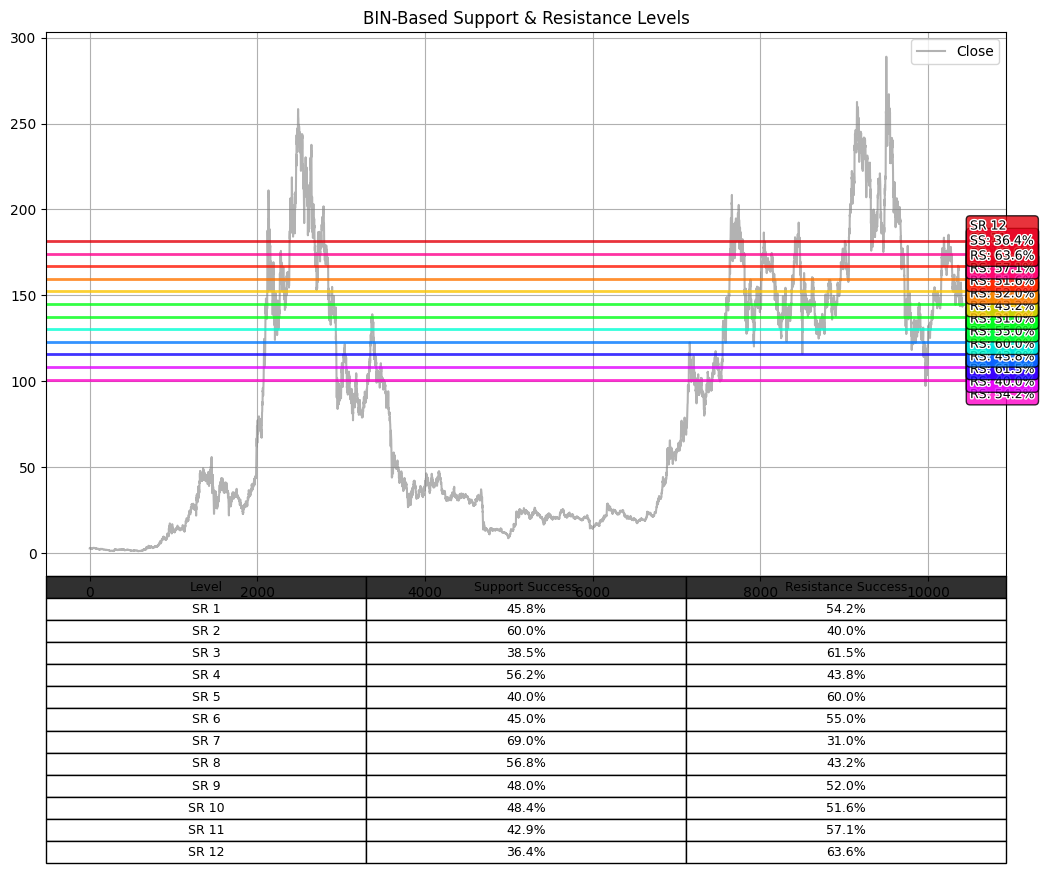

In [ ]:
#
bin_based_sr_plot(
    df=ohlcv,
    lookback=500,
    offset=100,
    display="both",  # options: "label", "table", "both"
    bins=12,         # or use `custom_levels=[...prices...]`
    export_path="sr_levels.png"
)


In [ ]:
import plotly.graph_objects as go


def bin_based_sr_plot_hover(
    df,
    lookback=500,
    offset=100,
    bins=10,
    custom_levels=None,
    display="both"
):
    df = df.copy()
    df = df[-lookback:].reset_index(drop=True)

    high, low, close = df["high"], df["low"], df["close"]

    max_p = close.max()
    min_p = close.min()

    if custom_levels:
        sr_levels = sorted(custom_levels)
        bins = len(sr_levels)
    else:
        step = (max_p - min_p) / bins
        sr_levels = [min_p + step * i for i in range(1, bins + 1)]

    def calculate_stats(level):
        bull_reject = (high.shift(2) >= level) & (close < level)
        bear_reject = (low.shift(2) <= level) & (close > level)
        bull_count = bull_reject.sum()
        bear_count = bear_reject.sum()
        total = bull_count + bear_count
        if total == 0:
            return 0, 0
        return round(bear_count / total * 100, 2), round(bull_count / total * 100, 2)

    support_success = []
    resistance_success = []

    for lvl in sr_levels:
        s, r = calculate_stats(lvl)
        support_success.append(s)
        resistance_success.append(r)

    # Gradient colors from Pine
    gradient_colors = [
        "#ff00c8", "#e100ff", "#0d00ff", "#007bff", "#00ffd5", "#00ff15",
        "#00ff15", "#ffc400", "#ff7700", "#ff1500", "#ff008c", "#e3000b"
    ][:bins]

    # Plot
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        y=close,
        x=df.index,
        mode='lines',
        name='Close',
        line=dict(color='white', width=1)
    ))

    for i, level in enumerate(sr_levels):
        fig.add_trace(go.Scatter(
            x=[0, lookback + offset],
            y=[level, level],
            mode="lines",
            name=f"SR {i+1}",
            line=dict(color=gradient_colors[i], width=2),
            hoverinfo="text",
            hovertext=(
                f"SR Level: {level:.2f}<br>"
                f"Support Success: {support_success[i]}%<br>"
                f"Resistance Success: {resistance_success[i]}%"
            ),
            showlegend=False
        ))

    if display in ["table", "both"]:
        table_data = {
            "SR Level": [f"{lvl:.2f}" for lvl in sr_levels],
            "Support Success (%)": support_success,
            "Resistance Success (%)": resistance_success
        }
        table_df = pd.DataFrame(table_data)
        print(table_df)

    fig.update_layout(
        title="Bin-Based Support and Resistance with Hover Tooltips",
        xaxis_title="Index",
        yaxis_title="Price",
        plot_bgcolor="black",
        paper_bgcolor="black",
        font=dict(color="white")
    )

    return fig


In [ ]:
#
fig = bin_based_sr_plot_hover(ohlcv)
fig.show()

  SR Level  Support Success (%)  Resistance Success (%)
0   106.17                46.67                   53.33
1   114.97                52.38                   47.62
2   123.76                72.22                   27.78
3   132.55                47.06                   52.94
4   141.34                60.00                   40.00
5   150.14                48.48                   51.52
6   158.93                53.33                   46.67
7   167.72                55.26                   44.74
8   176.52                40.91                   59.09
9   185.31                 0.00                  100.00


In [ ]:

def compute_bins(df, lookback=500, num_bins=10):
    recent_data = df.tail(lookback)
    min_price = recent_data['close'].min()
    max_price = recent_data['close'].max()
    bin_edges = np.linspace(min_price, max_price, num_bins + 1)
    return bin_edges


In [ ]:
def group_closes_by_bin(df, bin_edges):
    bin_means = []
    for i in range(len(bin_edges) - 1):
        in_bin = df['close'][(df['close'] >= bin_edges[i]) & (df['close'] < bin_edges[i+1])]
        if not in_bin.empty:
            bin_means.append(in_bin.mean())
        else:
            bin_means.append(None)
    return bin_means


In [ ]:
def calculate_statistics(df, level, lookback):
    highs = df['high'].shift(2)
    lows = df['low'].shift(2)
    closes = df['close']

    bull_rejects = ((highs >= level) & (closes < level)).sum()
    bear_rejects = ((lows <= level) & (closes > level)).sum()

    total = bull_rejects + bear_rejects
    if total == 0:
        return (0.0, 0.0)

    support_success = bear_rejects / total * 100
    resistance_success = bull_rejects / total * 100
    return support_success, resistance_success


In [ ]:
import plotly.graph_objects as go
from plotly.colors import qualitative

def plot_sr_lines(df, bin_levels, support_stats, resistance_stats, colors, offset=100):
    fig = go.Figure()

    # OHLC chart
    fig.add_trace(go.Candlestick(
        x=df.index, open=df['open'], high=df['high'],
        low=df['low'], close=df['close'], name="Price"))

    # Add SR lines
    for i, level in enumerate(bin_levels):
        if level is not None:
            fig.add_trace(go.Scatter(
                x=[df.index[-offset], df.index[-1]],
                y=[level, level],
                mode='lines',
                line=dict(color=colors[i % len(colors)], width=2),
                name=f"SR {i+1}",
                hovertemplate=f"<b>SR {i+1}</b><br>Level: {level:.2f}<br>Support Success: {support_stats[i]:.2f}%<br>Resistance Success: {resistance_stats[i]:.2f}%",
                showlegend=False
            ))

    fig.update_layout(title="Gradient SR Lines with Stats", hovermode="x unified")
    return fig


In [ ]:
lookback = 500
bin_edges = compute_bins(ohlcv, lookback)
bin_levels = group_closes_by_bin(ohlcv.tail(lookback), bin_edges)

support_stats, resistance_stats = zip(*[
    calculate_statistics(ohlcv.tail(lookback), level, lookback) if level else (0, 0)
    for level in bin_levels
])


In [ ]:
# Gradient colors similar to Pine Script
colors = [
    '#ff00c8', '#e100ff', '#0d00ff', '#007bff', '#00ffd5',
    '#00ff15', '#00ff15', '#ffc400', '#ff7700', '#ff1500', '#ff008c', '#e3000b'
]

fig = plot_sr_lines(ohlcv, bin_levels, support_stats, resistance_stats, colors)
fig.show()

## Birch Algorithm for Pivots


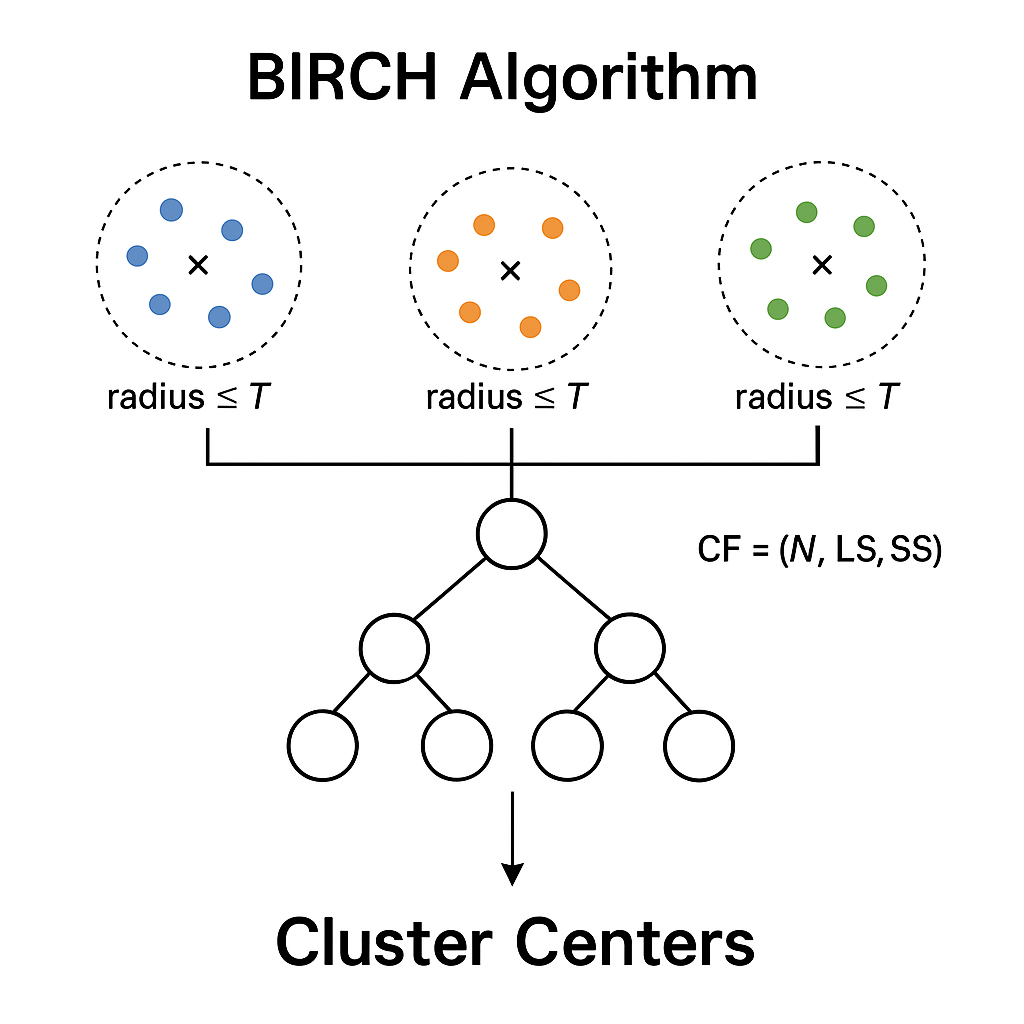


**The Chat**

https://chatgpt.com/c/68380a27-b8e4-8012-91ae-1b0c4348914f


### Normalize price for Birch threshold scaling (Custom Min-Max)

In [ ]:
# === STEP 2: Normalize price for Birch threshold scaling ===
normalized = (prices - prices.min()) / (prices.max() - prices.min())
X = normalized.reshape(-1, 1)

# === STEP 3: Run BIRCH clustering ===
model = Birch(threshold=0.09, branching_factor=50, n_clusters=None)
model.fit(X)
labels = model.predict(X)
centers = model.subcluster_centers_.flatten()

# === STEP 4: Organize results in a DataFrame ===
df = pd.DataFrame({
    "Date": dates,
    "Price": prices,
    "Normalized": normalized,
    "Cluster": labels
})
df

,Date,Price,Normalized,Cluster
0,2020-09-18 12:00:00,2.8929,0.005881,0
1,2020-09-18 16:00:00,3.1487,0.006770,0
2,2020-09-18 20:00:00,3.0994,0.006599,0
3,2020-09-19 00:00:00,3.1240,0.006684,0
4,2020-09-19 04:00:00,3.1044,0.006616,0
...,...,...,...,...
10405,2025-06-19 00:00:00,146.4300,0.504847,1
10406,2025-06-19 04:00:00,145.2900,0.500884,1
10407,2025-06-19 08:00:00,145.1800,0.500502,1
10408,2025-06-19 12:00:00,143.5000,0.494662,1


In [ ]:
centers

array([0.07209097, 0.54789972, 0.7673733 , 0.34985416, 0.14011514])

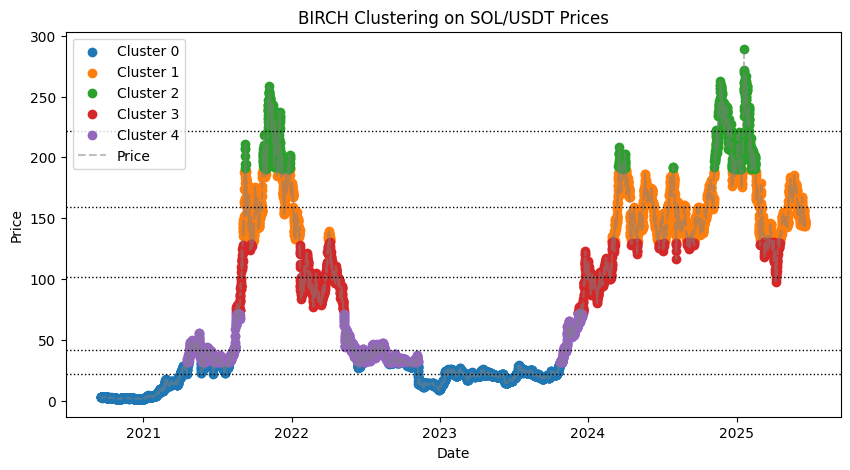

The ATH (last price point) falls into Cluster 1.


In [ ]:
# === STEP 5: Plot the clusters and cluster centers ===
plt.figure(figsize=(10, 5))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(dates[mask], prices[mask], label=f"Cluster {label}")
plt.plot(dates, prices, linestyle="--", alpha=0.5, color="gray", label="Price")

# Plot cluster centers as horizontal lines
for cen in centers:
    price_cen = cen * (prices.max() - prices.min()) + prices.min()
    plt.axhline(price_cen, linestyle=":", linewidth=1, color="black")

# plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"BIRCH Clustering on {INSTRUMENT} Prices")
plt.legend()
# plt.tight_layout()
plt.show()

# === STEP 6: Check cluster of last ATH point ===
last_label = labels[-1]
print(f"The ATH (last price point) falls into Cluster {last_label}.")


### BIRCH with raw price threshold

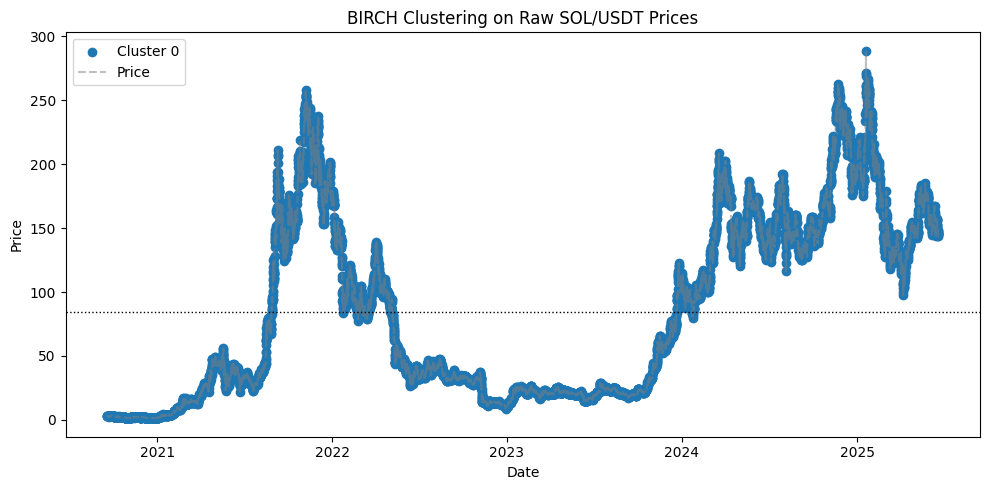

In [ ]:
# === STEP 2: Run BIRCH with raw price threshold ===
# Use an absolute price difference for threshold, e.g., $2,000
model = Birch(threshold=2000, branching_factor=50, n_clusters=None)
model.fit(prices.reshape(-1, 1))
labels = model.predict(prices.reshape(-1, 1))
centers = model.subcluster_centers_.flatten()

# === STEP 3: Organize results in a DataFrame ===
df = pd.DataFrame({
    "Date": dates,
    "Price": prices.flatten(),
    "Cluster": labels
})

# === STEP 4: Plot results ===
plt.figure(figsize=(10, 5))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(dates[mask], prices[mask], label=f"Cluster {label}")
plt.plot(dates, prices, linestyle="--", alpha=0.5, color="gray", label="Price")

# Plot raw-price cluster centers
for cen in centers:
    plt.axhline(cen, linestyle=":", linewidth=1, color="black")

# plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"BIRCH Clustering on Raw {INSTRUMENT} Prices")
plt.legend()
plt.tight_layout()
plt.show()


### Try price normalization using sklearn's MinMaxScaler

In [ ]:
# === STEP 2: Normalize price using MinMaxScaler ===
scaler = MinMaxScaler()
X = scaler.fit_transform(prices.reshape(-1, 1))

# === STEP 3: Run BIRCH clustering ===
model = Birch(threshold=0.05, branching_factor=50, n_clusters=None)
model.fit(X)
labels = model.predict(X)
centers = model.subcluster_centers_.flatten()

# === STEP 4: Denormalize centers for plotting ===
center_prices = scaler.inverse_transform(centers.reshape(-1, 1)).flatten()

# === STEP 5: Prepare DataFrame ===
df = pd.DataFrame({
    "Date": dates,
    "Price": prices,
    "Cluster": labels
})
df

,Date,Price,Cluster
0,2020-09-18 12:00:00,2.8929,0
1,2020-09-18 16:00:00,3.1487,0
2,2020-09-18 20:00:00,3.0994,0
3,2020-09-19 00:00:00,3.1240,0
4,2020-09-19 04:00:00,3.1044,0
...,...,...,...
10405,2025-06-19 00:00:00,146.4300,3
10406,2025-06-19 04:00:00,145.2900,3
10407,2025-06-19 08:00:00,145.1800,3
10408,2025-06-19 12:00:00,143.5000,3


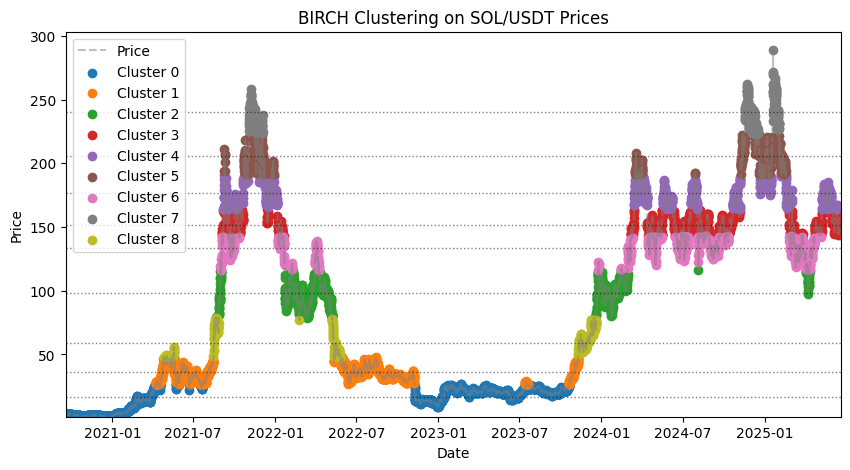

In [ ]:
# === STEP 6: Create static plot ===
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlim(dates.min(), dates.max())
ax.set_ylim(prices.min() * 0.95, prices.max() * 1.05)
ax.set_title(f"BIRCH Clustering on {INSTRUMENT} Prices")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

# Plot price path
ax.plot(dates, prices, linestyle="--", alpha=0.5, color="gray", label="Price")

# Plot clustered points
for label in np.unique(labels):
    mask = labels == label
    ax.scatter(dates[mask], prices[mask], label=f"Cluster {label}")

# Draw support/resistance zones
for cen in center_prices:
    ax.axhline(cen, linestyle=":", linewidth=1, color="black", alpha=0.5)

ax.legend(loc="upper left")
plt.show()

### Use OHLCV Data

Use Mid Prices => (high + low) / 2

Try:

- HLC3 => (high + low + close) / 3

In [ ]:
# === Normalize mid prices ===
mid_prices = ((ohlcv["high"] + ohlcv["low"]) / 2).values.reshape(-1, 1)
scaler = MinMaxScaler()
X = scaler.fit_transform(mid_prices)

# === Apply BIRCH clustering ===
model = Birch(threshold=0.05, branching_factor=50, n_clusters=None)
model.fit(X)
labels = model.predict(X)

In [ ]:
# model.n_clusters
model.subcluster_labels_

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
model.subcluster_centers_

array([[0.05379836],
       [0.12442804],
       [0.34789336],
       [0.53253781],
       [0.6186459 ],
       [0.71762644],
       [0.47168596],
       [0.84966571],
       [0.20423407]])

In [ ]:
# # Access the micro-clusters
# micro_clusters = model.subcluster_centers_

# # Get the count of points in each micro-cluster
# for i, micro_cluster in enumerate(micro_clusters):
#     count = micro_cluster.n_samples
#     print(f"Micro-cluster {i+1}: {count} points")

In [ ]:
# 4) Retrieve subcluster centers and label mapping
centers_scaled = model.subcluster_centers_
centers = scaler.inverse_transform(centers_scaled).flatten()
label_map = model.subcluster_labels_

label_map

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
# 5) Map each predicted label to corresponding cluster center
# label_map[i] tells you the label for subcluster_centers_[i]
# So: for each predicted label in labels, find the corresponding center
mapped_centers = np.array([centers[label_map == lbl][0] for lbl in labels])
mapped_centers

array([ 16.23983777,  16.23983777,  16.23983777, ..., 150.12179013,
       150.12179013, 150.12179013])

In [ ]:
# === Store cluster labels and calculate support/resistance ===
ohlcv["Cluster"] = labels
cluster_supports = ohlcv.groupby("Cluster")["low"].min().values
cluster_resistances = ohlcv.groupby("Cluster")["high"].max().values

In [ ]:
cluster_supports

array([  1.0818,  22.7358,  75.4354, 133.2255, 152.267 , 180.    ,
       110.1   , 214.0003,  43.3974])

In [ ]:
cluster_resistances

array([ 28.    ,  51.5392, 121.9605, 185.8372, 202.1198, 226.1056,
       147.06  , 294.94  ,  83.4399])

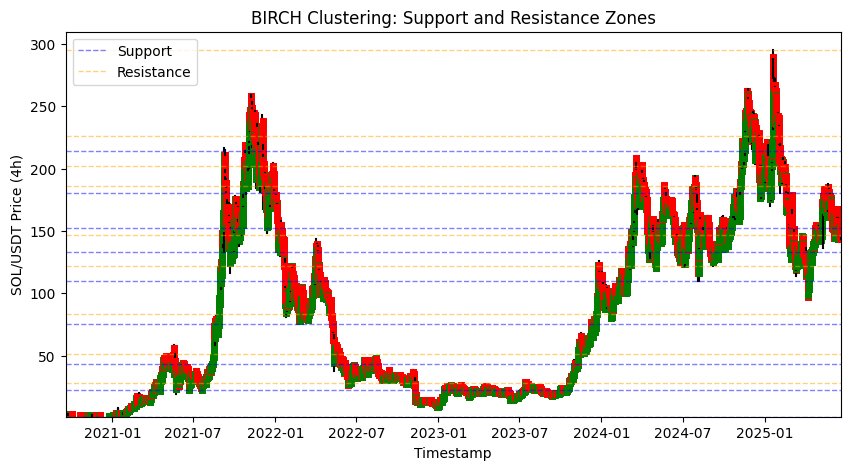

In [ ]:
# === Plot OHLC bars and zone overlays ===
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlim(ohlcv["timestamp"].min(), ohlcv["timestamp"].max())
ax.set_ylim(ohlcv["low"].min() * 0.95, ohlcv["high"].max() * 1.05)
ax.set_title("BIRCH Clustering: Support and Resistance Zones")
ax.set_xlabel("Timestamp")
ax.set_ylabel(f"{INSTRUMENT} Price ({TIMEFRAME})")

# Plot OHLC bars for all frames
for i in range(len(ohlcv)):
    color = "green" if ohlcv["close"][i] >= ohlcv["open"][i] else "red"
    ax.plot([ohlcv["timestamp"][i], ohlcv["timestamp"][i]], [ohlcv["low"][i], ohlcv["high"][i]], color="black")
    ax.plot([ohlcv["timestamp"][i], ohlcv["timestamp"][i]], [ohlcv["open"][i], ohlcv["close"][i]], color=color, linewidth=5)

# Plot support and resistance
for support in cluster_supports:
    ax.axhline(support, linestyle="--", color="blue", linewidth=1, alpha=0.5, label="Support")
for resistance in cluster_resistances:
    ax.axhline(resistance, linestyle="--", color="orange", linewidth=1, alpha=0.5, label="Resistance")

# Remove duplicate legend entries
handles, labels_unique = ax.get_legend_handles_labels()
by_label = dict(zip(labels_unique, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper left")

plt.show()
